# Credit Card Fraud Detection Project
##### **By Phillip Juricek**

## Overview
Credit card fraud poses a significant financial risk, costing institutions billions annually due to unauthorized transactions. Most fraud involves impersonation and rapid, hard-to-detect misuse of payment credentials.

This project aims to develop a high-recall machine learning model to detect fraudulent credit card transactions in real-time, minimizing financial loss and enabling proactive fraud mitigation. The solution is designed with a focus on handling class imbalance, optimizing the precision-recall tradeoff, and deploying a practical tool for real-world use.

The model is trained on the Kaggle Credit Card Fraud Detection dataset, which contains 284,807 anonymized transactions by European cardholders. Due to anonymization, features are labeled as V1 through V28, derived via PCA transformation, along with Time, Amount, and a binary fraud label.

---

## Challenges
A key challenge in this project is the extreme class imbalance. Fraudulent transactions represent only 0.172% of the dataset — fewer than 500 out of 284,807 records. A naive model could achieve over 99% accuracy simply by predicting every transaction as legitimate, while completely failing to detect fraud.

Therefore, traditional accuracy is misleading in this context. Our focus is on optimizing for recall and precision on the minority (fraud) class. The goal is to detect the rare, high-risk transactions without triggering an unmanageable number of false positives — a tradeoff that reflects real-world business constraints in fraud detection systems.

## First we will load in the neccessary libraries and our dataset.

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, average_precision_score
from sklearn.utils import resample

In [10]:
df_credit_card = pd.read_csv('creditcard.csv')

# Exploratory Data Analysis
#### Let us inspect data types, our first five entries, number of entries, number of missing values and number of nan values:

In [11]:
print(df_credit_card.head()) # inspect first five entries of dataset
print(df_credit_card.info()) # check for correct data types
print('shape of dataframe is: ', df_credit_card.shape) # check how many data entries
print('The number of null values in the dataset are: ', df_credit_card.isnull().sum()) # Check for missing values
print('The number of nan values in the dataset are: ', df_credit_card.isna().sum()) #check for nan values

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

##### Luckily, everything in our dataset appears nicely prepared for us therefore we do not need to preprocess the data
#####To gain a better understanding of the class distribution let us visualize the percentage of fraud (Class = 1) vs the percentage of non fraud (Class = 0) in the form of a pie chart.

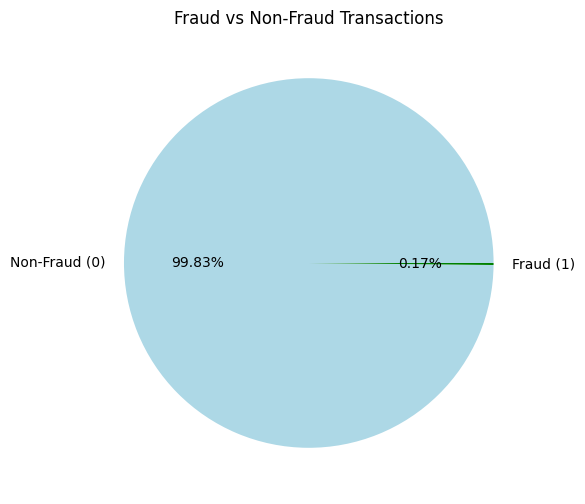

In [12]:
fraud_counts = df_credit_card['Class'].value_counts()

# Rename the index to more readable labels
fraud_counts.index = ['Non-Fraud (0)', 'Fraud (1)']

# Plot using pandas
fraud_counts.plot(kind='pie', autopct='%1.2f%%', figsize=(6, 6), title='Fraud vs Non-Fraud Transactions', ylabel='', colors=['lightblue', 'green'])

plt.show()

##### looking at this visual we confirm that <0.2% of the data is of fraudulent cases, therefore before training our models we will need to addresss this imbalance to avoid overfitting.



#Data Preparation and Modeling
#### To better prepare our data for training our model we will use a technique called resampling, this method infers new likely cases from our existing dataset and will effectively double our datasets size to make our split between fraudulent and non fraudulent cases 50/50.

#### The reason we are upsampling our minority cases instead of downsampling our majority cases is that doing the former would significantly lower our overall data, this would make training our model faster but would hinder model accuracy in the long run.

##### Firstly to avoid data leakage let us split our data into features and then use train test split immediately. This will ensure that our model cannot peek at the training data.

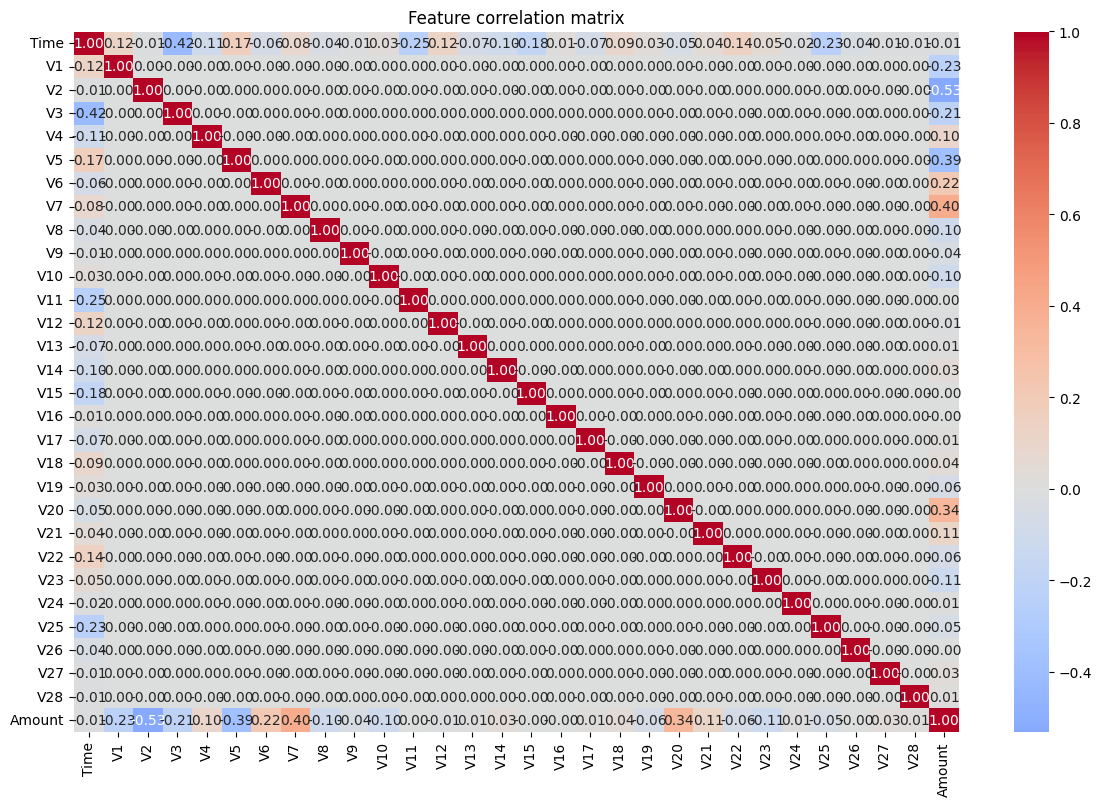

In [30]:
# Create features
x = df_credit_card.drop(['Class'], axis=1)

y = df_credit_card['Class']

# Let us check our correlation matrix to check for redundant features
plt.figure(figsize=(12,8))
correlation_matrix = x.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm',center=0, annot=True, fmt='.2f')
plt.tight_layout()
plt.title('Feature correlation matrix')
plt.show()

#### Seeing as none of our variable have a correlation score higher than 0.85 we will keep all of our features as they are all relevant.

In [31]:
#now we split our data into a training and testing set
x_train, x_test, y_train, y_test = train_test_split(x ,y ,test_size=0.2 , random_state=42, stratify=y)

##### Now let us resample our data to address the severe class imnbalance

In [14]:
# Resampling
df_train = x_train.copy()
df_train['Class'] = y_train

df_majority = df_train[df_train['Class'] == 0] # seperate majority and minority
df_minority = df_train[df_train['Class'] == 1]

df_minority_upsampled = resample(df_minority, # upsample our minority
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

# bring back together our rebalanced dataset
df_train_balanced = pd.concat([df_majority, df_minority_upsampled]).sample(frac=1, random_state=42)

y_train_balanced = df_train_balanced['Class']
x_train_balanced = df_train_balanced.drop('Class', axis=1)

##### Just to be sure that our transofrmation worked let us inspect our dataset size and then visualize our new data distribution with a pie chart. if our transformation worked our dataset should double in size and our class disrtibution should be 50/50.

the number of entries in our balanced dataset is:  454902


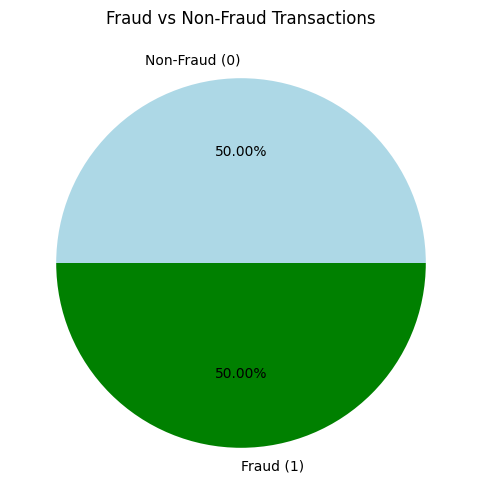

In [15]:
print('the number of entries in our balanced dataset is: ', df_train_balanced.shape[0])
# lets replot our data to visualize the changes
fraud_counts = df_train_balanced['Class'].value_counts()

# Rename the index to more readable labels (optional)
fraud_counts.index = ['Non-Fraud (0)', 'Fraud (1)']

# Plot using pandas
fraud_counts.plot(kind='pie', autopct='%1.2f%%', figsize=(6, 6), title='Fraud vs Non-Fraud Transactions', ylabel='', colors=['lightblue', 'green'])

plt.show()

#### Seeing as our dataset doubled in size and we now have the correct distribution we may move on to scaling our features and training our models.

#### Firstly let us scale our features

In [16]:
scale = StandardScaler()

x_train_scaled = scale.fit_transform(x_train_balanced)
x_test_scaled = scale.transform(x_test)

#### Next let us create three different models, a RandomForest, Logistic Regression and XGBoost.

In [17]:
#Create RandomForest Model
rf_model = RandomForestClassifier(
    n_estimators =100,
    max_depth=10,
    min_samples_split = 5,
    random_state=42
    )
# Create Logistic Regression model
lr_model = LogisticRegression(solver='liblinear',
                              random_state=42
                              )
# Create XGBoost Model
XGB_model = XGBClassifier(use_label_encoder = False,
                          eval_metric='logloss',
                          random_state=42
                          )

#### Testing them:
##### Before fitting our models, we’ll use cross-validation scores to estimate model performance. We’ll use a Stratified K-Fold method to ensure that class imbalance is preserved in each fold. This will give us an early indication of which model might perform best.

##### Our scoring metric will be average_precision, which represents the area under the precision-recall curve. For imbalanced datasets, this is often more informative than ROC AUC, as it better reflects the model’s ability to correctly identify the minority class. The model with the highest average precision score will likely have the best trade-off between precision and recall — which is critical in applications like fraud detection.

In [18]:
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)

# Get cross validation scores for RandomForest
rf_scores = cross_val_score(rf_model, x_train, y_train, cv=skf, scoring='average_precision')
print('mean randomforest precision score is:', rf_scores.mean())

# Get cross validation scores for Linear Regression model
lr_scores = cross_val_score(lr_model, x_train, y_train, cv=skf, scoring='average_precision')
print('mean linear regression precision score is:', lr_scores.mean())

# Get cross validation scores for XGBoost model
XGB_scores = cross_val_score(XGB_model, x_train, y_train, cv=skf, scoring='average_precision')
print('mean XGB precision score is: ', XGB_scores.mean())

mean randomforest precision score is: 0.833309214109609
mean linear regression precision score is: 0.6116835194489705


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:34:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:34:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:34:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:34:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:34:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

mean XGB precision score is:  0.8535434650501124


#### Seeing that our mean linear regression precision score is the lowest (0.612) vs random forest's 0.83 and XGBoost's 0.85 I decided to only move forwards with fitting the random forest and XGB models.

In [19]:
# Fit RandomForest Model
rf_model.fit(x_train_scaled, y_train_balanced)

# Fit XGBoost model
XGB_model.fit(x_train_scaled, y_train_balanced)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

# Model Performance Evaluation and Adjustment

#### Let us generate classification reports for our two best performing models

In [20]:
y_pred_rf = rf_model.predict(x_test_scaled)

y_pred_XGB = XGB_model.predict(x_test_scaled)

print('RandomForest Classification Report: \n')
print(classification_report(y_test,y_pred_rf))

print('XGBoost Classification Report: \n')
print(classification_report(y_test,y_pred_XGB))


RandomForest Classification Report: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.65      0.86      0.74        98

    accuracy                           1.00     56962
   macro avg       0.82      0.93      0.87     56962
weighted avg       1.00      1.00      1.00     56962

XGBoost Classification Report: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.84      0.85        98

    accuracy                           1.00     56962
   macro avg       0.93      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



#### To better interpret these results let us visualize the two models performances using a confusion matrix.

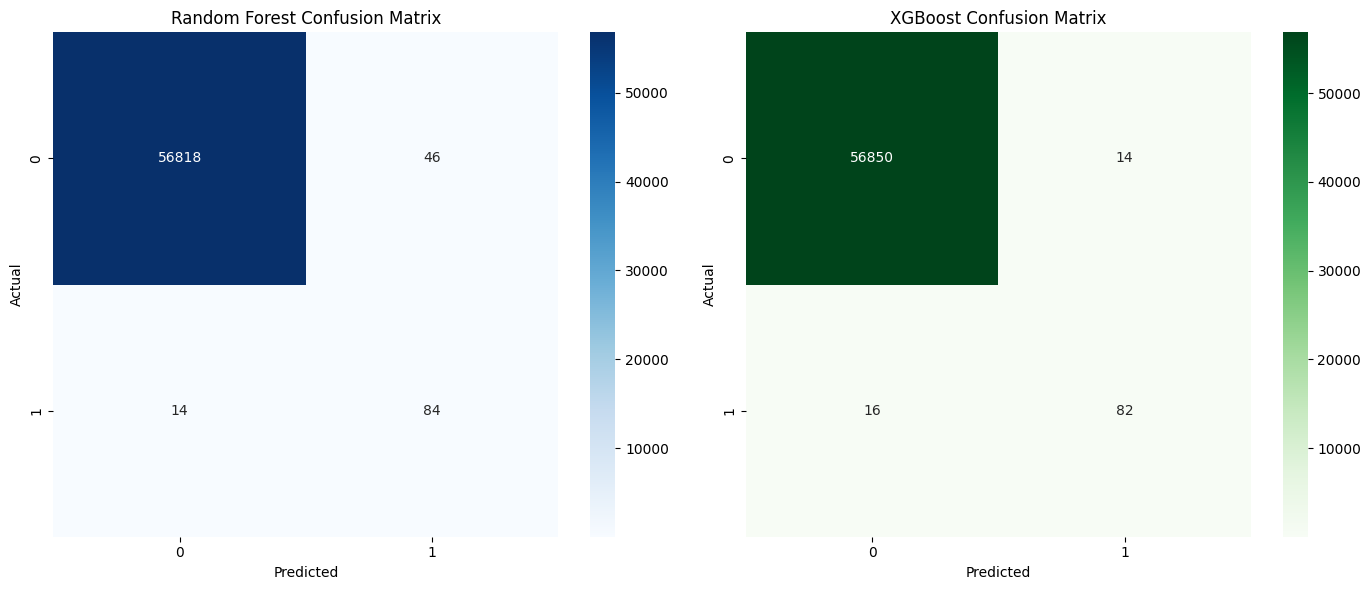

In [21]:
plt.figure(figsize=(14,6))

cm_rf = confusion_matrix(y_test,y_pred_rf)
cm_XGB = confusion_matrix(y_test,y_pred_XGB)

plt.subplot(1, 2, 1)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(cm_XGB, annot=True, fmt='d', cmap='Greens')
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


#### Overall the models both perform very well, before deciding on which model to choose let us check our features for correlation and see if there are any redundant features.

In [24]:
importance_rf = rf_model.feature_importances_
feature_imp_rf = pd.DataFrame({'Feature':x.columns,
                            'Importance':importance_rf}).sort_values('Importance', ascending=False)
print('RandomForest Feature importance: \n')
print(feature_imp_rf.head())

importance_XGB = XGB_model.feature_importances_
feature_imp_XGB = pd.DataFrame({'Feature':x.columns,
                            'Importance':importance_XGB}).sort_values('Importance', ascending=False)

print('XGBoost Feature Importance: \n')
print(feature_imp_XGB.head())



RandomForest Feature importance: 

   Feature  Importance
14     V14    0.196055
10     V10    0.119030
4       V4    0.110259
12     V12    0.102510
17     V17    0.088086
XGBoost Feature Importance: 

   Feature  Importance
14     V14    0.588499
4       V4    0.070515
12     V12    0.040660
7       V7    0.026927
20     V20    0.025077


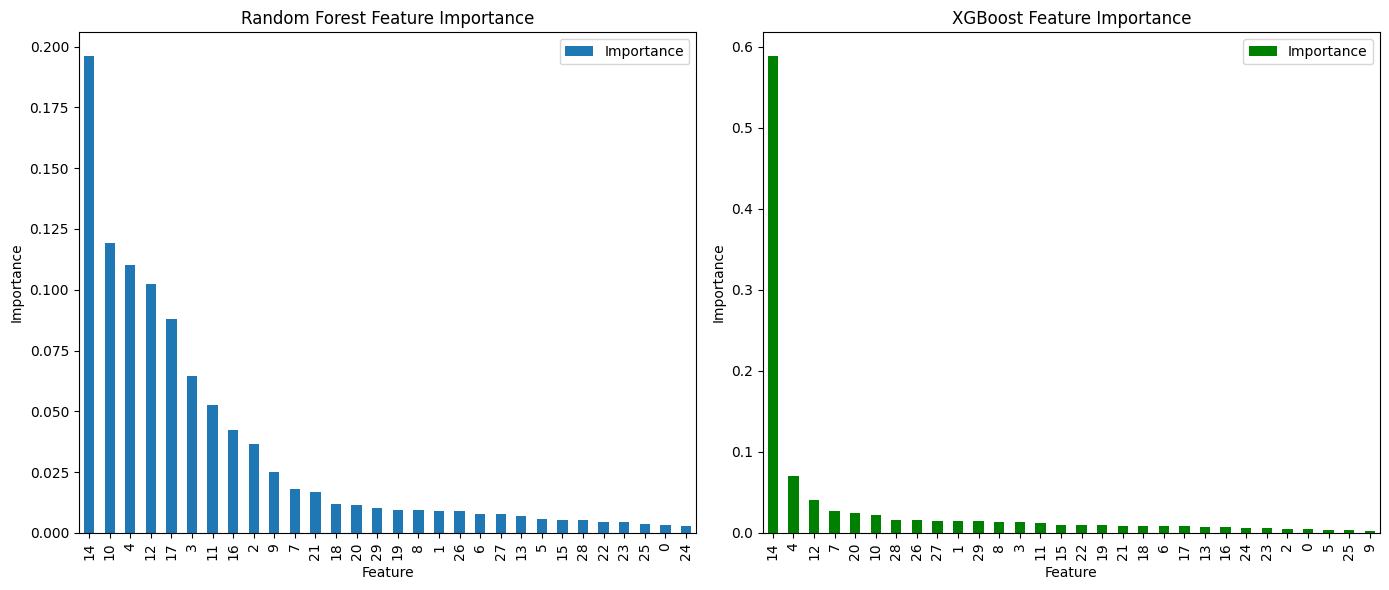

In [36]:

plt.figure(figsize=(14,6))

ax1 = plt.subplot(1, 2, 1)
feature_imp_rf.plot(kind='bar', ax=ax1)
plt.title('Random Forest Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Feature')

ax2 = plt.subplot(1, 2, 2)
feature_imp_XGB.plot(kind='bar', ax=ax2, color='green')
plt.title('XGBoost Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Feature')

plt.tight_layout()
plt.show()


#### This is interesting, XGB prioritizes feature 14  a lot more than random forest. I wonder why.

#### next let us visualize both models precision recall curves, this will hopefully give us a better understanding of which is for sure the best model


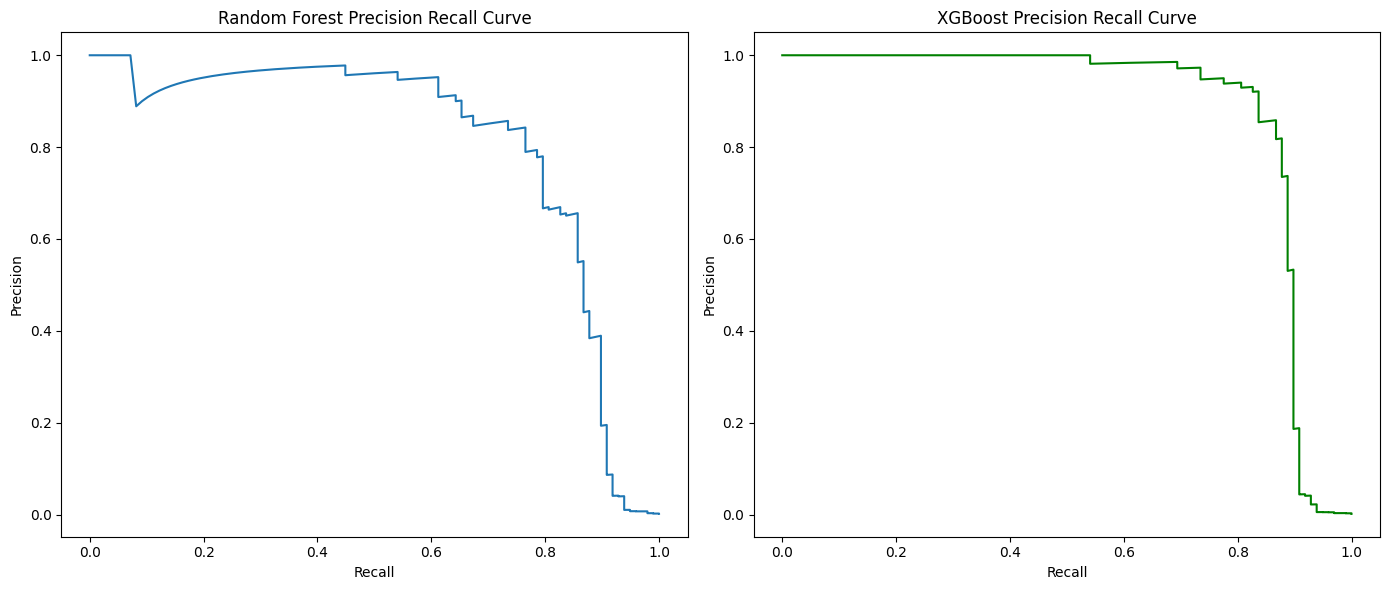

In [35]:
y_pred_proba_rf = rf_model.predict_proba(x_test_scaled)[:,1]
y_pred_proba_XGB = XGB_model.predict_proba(x_test_scaled)[:,1]

precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_pred_proba_rf)
precision_XGB, recall_XGB, thresholds_XGB = precision_recall_curve(y_test, y_pred_proba_XGB)

pr_auc_rf = average_precision_score(y_test, y_pred_proba_rf)
pr_auc_XGB = average_precision_score(y_test, y_pred_proba_XGB)

plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.plot(recall_rf, precision_rf, label=f'PR Curve RandomForest (AUC = {pr_auc_rf:.2f})')
plt.title('Random Forest Precision Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.subplot(1, 2, 2)
plt.plot(recall_XGB, precision_XGB, label=f'PR Cruve XGBoost (AUC= {pr_auc_XGB:.2f})', color='green')
plt.title('XGBoost Precision Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.tight_layout()
plt.show()


### Judging from these curves it seems likely that XGBoost is the superior model as its curve is farther to the top right indicating better precision and recall overall.

#### From the classification report, cross validation and now the Precision recall curve we can safely assume that XGBoost is the better performing model.

#### Let us now tune XGBoost to prioritize a bit more recall since it is important to catch fraudulent cases.

##### To get a better idea of what our threshold will be we can utilize a quick visual.

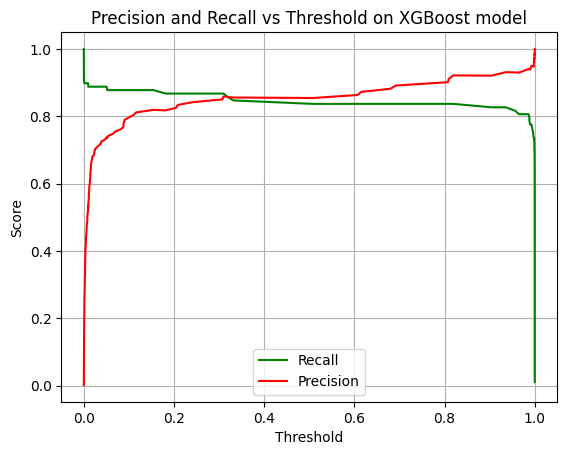

In [37]:
plt.plot(thresholds_XGB, recall_XGB[:-1], label='Recall', color='green')
plt.plot(thresholds_XGB, precision_XGB[:-1], label='Precision', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold on XGBoost model')
plt.legend()
plt.grid(True)
plt.show()

#### since we wanta. balance of Recall and Precision we will optimize for f1 score, f1 score provides a good balance of false positives and negatives. If flagging fraud was of our utmost importance we would instead optimize for recall but this might be costlier to the bank since they would have to spend more resources calling people, thus we will optimize for f1 even though it does not catch as much as optimizing purely for recall would.

In [38]:
f1_scores_XGB = 2*(precision_XGB*recall_XGB)/(precision_XGB+recall_XGB)
optimal_index_XGB = f1_scores_XGB.argmax()
optimal_threshold_XGB = thresholds_XGB[optimal_index_XGB]

print("Optimal Threshold (F1):", optimal_threshold_XGB)
print("F1 Score at Optimal Threshold:", f1_scores_XGB[optimal_index_XGB])

Optimal Threshold (F1): 0.8193618
F1 Score at Optimal Threshold: 0.877005347593583


#### Now let us apply our optimized threshold

In [41]:
optimized_y_pred_XGB = (y_pred_proba_XGB >= optimal_threshold_XGB).astype(int)
print('optimized classification report for XGBoost is: \n')
print(classification_report(y_test, optimized_y_pred_XGB))

optimized classification report for XGBoost is: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.84      0.88        98

    accuracy                           1.00     56962
   macro avg       0.96      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962



#### let us now revisualize our confusion matrix before and after optimization of the model

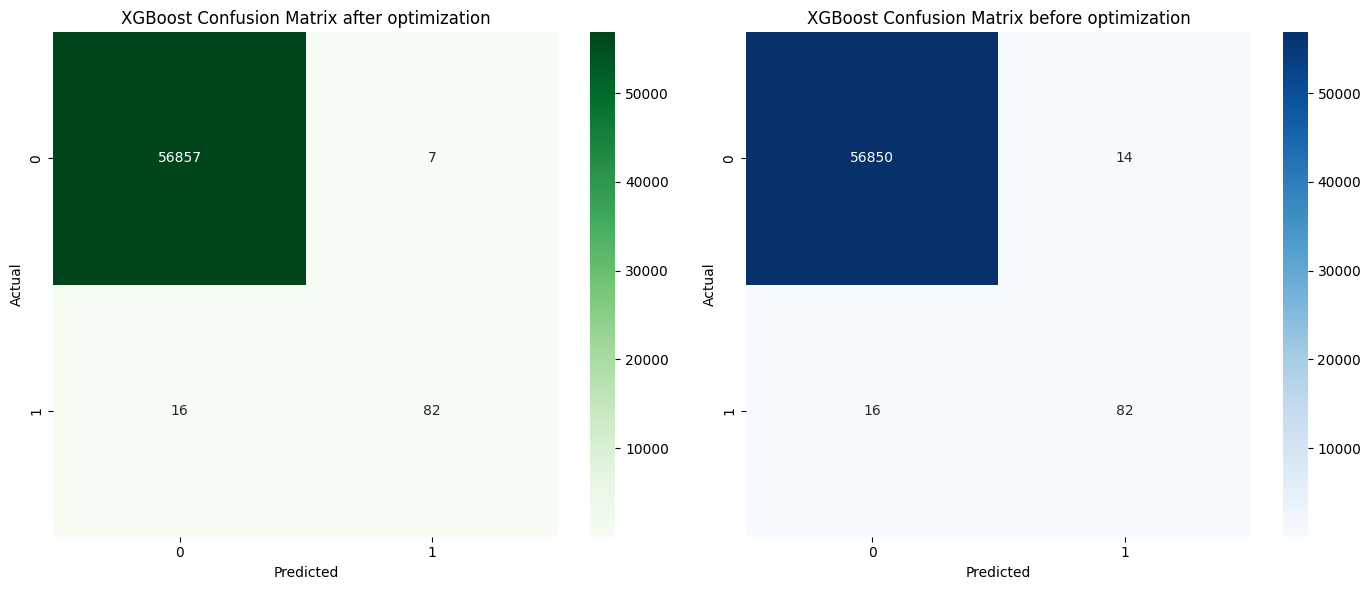

In [49]:
plt.figure(figsize=(14,6))

cm_XGB_optimized = confusion_matrix(y_test, optimized_y_pred_XGB)
cm_XGB = confusion_matrix(y_test,y_pred_XGB)

plt.subplot(1, 2, 1)
sns.heatmap(cm_XGB_optimized, annot=True, fmt='d', cmap='Greens')
plt.title('XGBoost Confusion Matrix after optimization')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(cm_XGB, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix before optimization')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

#### Although the performance is only slightly better this would still be important as when working with massive amounts of data even small percentage imrpovements scale.

# Conclusion

In this notebook, we built a machine learning model to detect credit card fraud. We evaluated three different classifiers: **Logistic Regression**, **Random Forest**, and **XGBoost**.

After comparing their performance, **XGBoost** was selected as the final model due to its superior **F1 score**, which provided a strong balance between **precision** and **recall** — both critical metrics in fraud detection scenarios.

To address the issue of class imbalance, we applied **resampling techniques** to ensure that the model learned effectively from the minority (fraud) class. We also optimized the model’s **decision threshold** by selecting the value that maximized the F1 score, rather than using the default threshold of 0.5. This approach improved the model’s ability to detect fraudulent transactions while minimizing false alarms.

Effective fraud detection is of significant importance to businesses, particularly in the financial sector. Early and accurate identification of fraudulent transactions helps reduce financial losses, protect customer trust, and maintain the integrity of payment systems. A well-tuned machine learning model enables organizations to act quickly and decisively, balancing security with user experience.

## Thanks for making it to the end

##### By: Phillip Juricek